In [1]:
#| default_exp utils
# all_slow

In [2]:
#| include: false
# ! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

In [3]:
#| include: false
# load google drive directory on colab
# import os
# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir("/content/drive/MyDrive/Colab Notebooks/severstal")

In [4]:
#| include: false
# !pip install -Uqq fastai --upgrade

In [5]:
#| include: false
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
#| export
from fastai.vision.all import *
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt

In [7]:
import fastai
print(fastai.__version__)

2.5.2


In [8]:
#| export
palet = [
    (249, 192, 12), # ClassId 1
    (0, 185, 241),  # ClassId 2
    (114, 0, 218),  # ClassId 3
    (249,50,12)     # ClassId 4
]

In [9]:
#| export
def seed_everything(seed=69):
    """
    Seeds `random`, `os.environ["PYTHONHASHSEED"]`,
    `numpy`, `torch.cuda` and `torch.backends`.
    """
    warnings.filterwarnings("ignore")
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

## Data structure

In [10]:
#| export
def print_competition_data(p: Path):
    for elem in p.ls():
        print(elem)

In [11]:
path = Path("../data/")

The `path` variable is a `os.pathlib.Path` object that points to the competition data.

To print all the files this directory use the `print_competition_data` function.

In [12]:
print_competition_data(path)

..\data\hard_negatives_patterns.txt
..\data\predictions
..\data\sample_submission.csv
..\data\submissions
..\data\test_images
..\data\train.csv
..\data\train_images


The competition files in detail: 

- **train_images/** - folder of training images (12.5k images)
- **test_images/** - folder of test images to segment and classify (5506 images)
- **train.csv** - training annotations which provide segments for defects (`ClassId = [1, 2, 3, 4]`)
- **sample_submission.csv** - a sample submission file in the correct format; note, each `ImageId` 4 rows, one for each of the 4 defect classes


In [13]:
train_path = path/"train_images"
test_path = path/"test_images"
train_pfiles = get_image_files(train_path)
test_pfiles = get_image_files(test_path)

## Training data

The training data includes:

- faulty images: images that have at least one defect

- hard negative images: images with no defects

In [14]:
train_pfiles

(#12568) [Path('../data/train_images/0002cc93b.jpg'),Path('../data/train_images/00031f466.jpg'),Path('../data/train_images/000418bfc.jpg'),Path('../data/train_images/000789191.jpg'),Path('../data/train_images/0007a71bf.jpg'),Path('../data/train_images/000a4bcdd.jpg'),Path('../data/train_images/000f6bf48.jpg'),Path('../data/train_images/0014fce06.jpg'),Path('../data/train_images/001982b08.jpg'),Path('../data/train_images/001d1b355.jpg')...]

The `get_train_df` function returns the DataFrame from the `train.csv` file, only faulty image names if `only_faulty`, with the training images metadata:
- **ImageId**: image name

- **ClassId**: the class type

- **EncodedPixels**: the encoded pixels follows a run-length encoding rule, a sequence of pair values that contains a start position and a run length with the space as the delimiter. E.g. `1 3 10 5` means pixels `(1,2,3)` and `(10,11,12,13,14)`.  

Each Image may have no defects, a single defect, or multiple defects.

In [15]:
#| export
def get_train_pivot(df):
    """
    Summarize the training csv with ClassId as columns and values EncodedPixels
    """
    def rles2classids(s: pd.Series):
        classids = []
        for classid in s.index:
            if classid != "n":
                value = s[classid]
                if not (value is np.nan): 
                    classids.append(str(classid))
        return " ".join(classids)

    train_pivot = df.pivot(
        index="ImageId", columns="ClassId", values="EncodedPixels")
    train_pivot["n"] = train_pivot.notnull().sum(1)
    train_pivot["ClassIds"] = train_pivot.apply(rles2classids, axis=1)
    return train_pivot

def get_train_df(path, only_faulty=False, pivot=False, hard_negatives=False):
    """
    Get training DataFrame with all the images in data/train_images.
    Returns only the faulty images if `only_faulty`.
    """
    img_path = path/"train_images"
    csv_file_name = path/"train.csv"
    
    train = pd.read_csv(csv_file_name)
    
    img_names = [img.name for img in get_image_files(img_path)]    
    df_all = pd.DataFrame({'ImageId': img_names})
    
    train_all = pd.merge(df_all, train, on="ImageId", how="outer", indicator=True)
    
    # Renaming and fillna
    train_all.rename(columns={'_merge': 'status'}, inplace=True)
    rename_dict = {"both": "faulty", "left_only": "no_faulty", "right_only": "missing"}
    train_all["status"] = train_all["status"].cat.rename_categories(rename_dict)
    train_all = train_all[train_all["status"]!="missing"]

    train_all.ClassId.fillna(0, inplace=True)
    train_all.ClassId = train_all.ClassId.astype('int64')
    
    train_all.EncodedPixels.fillna(-1, inplace=True)
    train_all["ImageId_ClassId"] = train_all["ImageId"] + "_" + train_all["ClassId"].astype('str')
    
    if hard_negatives:
        hard_neg_patterns = pd.read_csv(
            path/"hard_negatives_patterns.txt", header=None, names=["ImageId"])
        cond = train_all["status"]=="faulty"
        cond_hn = train_all["ImageId"].isin(hard_neg_patterns["ImageId"].tolist())
        train_all = train_all.loc[cond | cond_hn]
    if only_faulty:
        train_all = train_all[train_all["status"]=="faulty"]
    if pivot:
        return get_train_pivot(train_all)
        
    return train_all 

### Hard negatives with patterns

In [16]:
hard_neg_patterns = pd.read_csv(
    path/"hard_negatives_patterns.txt", header=None, names=["ImageId"])

In [17]:
hard_neg_patterns.head()

ImageId
0  000789191.jpg 
1  00d7ae946.jpg 
2  01b237ab8.jpg 
3   01d590c5f.jpg
4  01e501f99.jpg

In `hard_neg_patterns` there are the `ImageId`s of training images with some patterns (from this [kernel](https://www.kaggle.com/ateplyuk/detector-steels-with-texture/data)).

In [18]:
train = get_train_df(path, only_faulty=False)
assert isinstance(train, pd.DataFrame)
train_faulty = train.loc[train["status"]=="faulty"]
assert not train.ImageId_ClassId.duplicated().any(), "Found ImageId_ClassId duplicates"

In [19]:
train.describe(include='all')[:4]

ImageId  ClassId  EncodedPixels  status  ImageId_ClassId
count           12997  12997.0        12997.0   12997            12997
unique          12568      NaN         7096.0       2            12997
top     ef24da2ba.jpg      NaN           -1.0  faulty  0002cc93b.jpg_1
freq                3      NaN         5902.0    7095                1

In [20]:
print(train.shape)
train.head(2)

(12997, 5)


ImageId  ClassId  \
0  0002cc93b.jpg        1   
1  00031f466.jpg        0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             EncodedPixels  \
0  29102 12 29346 24 29602 24 29858 24 30114 24 30370 24 30626 24 30882 24 31139 23 31395 23 31651 23 31907 23 32163 23 32419 23 32675 23 77918 27 78174 55 78429 60 78685 64 78941 68 79197 72 79452 77 79708 81 79964 85 80220 89 80475 94 80731 98 80987 102 81242 105 81498 105 81754 104 82010 104 82265 105 82521 31 82556 69 82779 27 82818 63 83038 22 83080 57 83297 17 83342 50 83555 13 83604 44 83814 8 83866 37 84073 3 84128 31 84390 25 84652 18 84918 8 85239 10 85476 29 85714 47 85960 57 86216 57 86471 58 86727 58 86983 58 87238 59 87494 59 87750 59 88005 60 88261 60 88517 60 88772 61 89028 53...   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       -1   

      status  ImageId_ClassId  
0     faulty  0002cc93b.jpg_1  
1  no_faulty  00031f466.jpg_0

In [21]:
missing_imgs = train["ImageId"].map(lambda x: not ((path/"train_images"/str(x)).is_file()))
print(missing_imgs.sum())

0


In [22]:
print(train_faulty.shape)
train_faulty.head(2)

(7095, 5)


ImageId  ClassId  \
0  0002cc93b.jpg        1   
4  0007a71bf.jpg        3   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             EncodedPixels  \
0  29102 12 29346 24 29602 24 29858 24 30114 24 30370 24 30626 24 30882 24 31139 23 31395 23 31651 23 31907 23 32163 23 32419 23 32675 23 77918 27 78174 55 78429 60 78685 64 78941 68 79197 72 79452 77 79708 81 79964 85 80220 89 80475 94 80731 98 80987 102 81242 105 81498 105 81754 104 82010 104 82265 105 82521 31 82556 69 82779 27 82818 63 83038 22 83080 57 83297 17 83342 50 83555 13 83604 44 83814 8 83866 37 84073 3 84128 31 84390 25 84652 18 84918 8 85239 10 85476 29 85714 47 85960 57 86216 57 86471 58 86727 58 86983 58 87238 59 87494 59 87750 59 88005 60 88261 60 88517 60 88772 61 89028 53...   
4                                                                                                                                                                                                                     18661 28 18863 82 19091 110 19347 110 19603 110 19859 110 20115 110 20371 110 20627 110 20883 110 21139 110 21395 110 21651 110 21962 55 293125 251 293381 251 293637 251 293893 251 294149 251 294405 251 294661 251 294917 251 295173 251 295429 251 295685 251 295941 251 296197 251 296453 251 296709 251 296965 251 297221 251 297477 251 297733 251 297989 251 298245 251 298564 188 298945 63   

   status  ImageId_ClassId  
0  faulty  0002cc93b.jpg_1  
4  faulty  0007a71bf.jpg_3

In [23]:
#| export
def count_pct(df, column="ClassId"):
    """Returns a `pandas.DataFrame` with count and frequencies stats for `column`."""
    class_count = df[column].value_counts().sort_index()
    class_count.index.set_names(column, inplace=True)
    class_count = class_count.to_frame()
    class_count.rename(columns={column: "num"}, inplace=True)
    return class_count.assign(freq=lambda df: df["num"] / df["num"].sum())

The `ClassId` column values from `train` are:

In [24]:
class_count = count_pct(train)
class_count

num      freq
ClassId                
0        5902  0.454105
1         897  0.069016
2         247  0.019004
3        5150  0.396245
4         801  0.061630

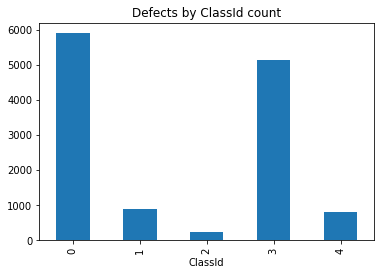

In [25]:
class_count["num"].plot.bar(title="Defects by ClassId count");

Images have at least one defect and there's a small number of images with two or three defects. 

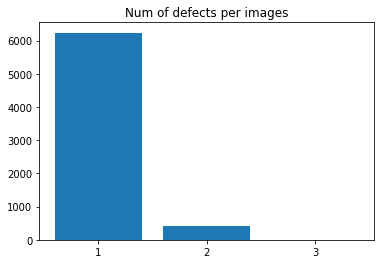

{1: 6239, 2: 425, 3: 2}

In [26]:
counts = train_faulty["ImageId"].value_counts()

hist_counts, _ = np.histogram(counts.values, bins=3)
nums = ['1', '2', '3']
plt.bar(x=nums, height=hist_counts)
plt.title("Num of defects per images")
plt.show()

{i+1: c for i, c in enumerate(hist_counts)}

In [27]:
unique_imgs = train_faulty.describe(include='all')["ImageId"].T[:2]
unique_imgs

count     7095
unique    6666
Name: ImageId, dtype: object

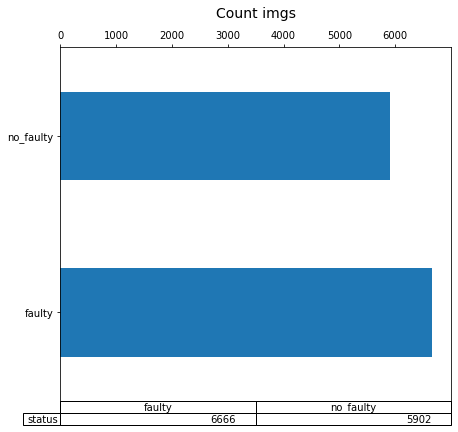

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6.5))
ax.set_title("Count imgs", pad=30, fontdict={'fontsize': 14})
ax.xaxis.tick_top()  # Display x-axis ticks on top

(
    train[['ImageId', 'status']]
    .drop_duplicates()
    .status.value_counts().iloc[:-1]
    .plot.barh(table=True, ax=ax)
)
plt.show()

## Train transforms

Loading the images for models requires some transformations to the DataFrames.

### Pivot RLE encodings

The `get_train_pivot` is the pivoted version of `df`. All the images are in the index, for each image the `ClassId` encoding values are in the columns.

In [29]:
train_pivot = get_train_df(path, pivot=True)

In [30]:
train_pivot.head(2)

ClassId          0  \
ImageId              
0002cc93b.jpg  NaN   
00031f466.jpg   -1   

ClassId                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              1  \
ImageId                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
0002cc93b.jpg  29102 12 29346 24 29602 24 29858 24 30114 24 30370 24 30626 24 30882 24 31139 23 31395 23 31651 23 31907 23 32163 23 32419 23 32675 23 77918 27 78174 55 78429 60 78685 64 78941 68 79197 72 79452 77 79708 81 79964 85 80220 89 80475 94 80731 98 80987 102 81242 105 81498 105 81754 104 82010 104 82265 105 82521 31 82556 69 82779 27 82818 63 83038 22 83080 57 83297 17 83342 50 83555 13 83604 44 83814 8 83866 37 84073 3 84128 31 84390 25 84652 18 84918 8 85239 10 85476 29 85714 47 85960 57 86216 57 86471 58 86727 58 86983 58 87238 59 87494 59 87750 59 88005 60 88261 60 88517 60 88772 61 89028 53...   
00031f466.jpg                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      NaN   

ClassId          2    3    4  n ClassIds  
ImageId                                   
0002cc93b.jpg  NaN  NaN  NaN  1        1  
00031f466.jpg  NaN  NaN  NaN  1        0

In [31]:
count_pct(train_pivot, column='n')

num      freq
n                 
1  12141  0.966025
2    425  0.033816
3      2  0.000159

In [32]:
count_pct(train_pivot, column='ClassIds').sort_values("freq")

num      freq
ClassIds                
2 4          1  0.000080
1 2 3        2  0.000159
2 3         14  0.001114
1 2         35  0.002785
1 3         91  0.007241
2          195  0.015516
3 4        284  0.022597
4          516  0.041057
1          769  0.061187
3         4759  0.378660
0         5902  0.469605

### Multi class defects

The `get_classification_df` allows to build a DataFrame to classification models. In `ClassId_multi` are listed the `ClassId`s separated by a space.

In [33]:
#| export
def get_classification_df(df: pd.DataFrame):
    """
    Get the DataFrame for the multiclass classification model
    """

    def assign_multi_ClassId(x):
        """Returns a string with multi ClassId sep with a blank space (' ')"""
        def fill_cols(c):
            return c.fillna(5).astype('int64').astype(str)

        cols = [fill_cols(x[i]) for i in range(5)]
        cols = [col.replace('5', '') for col in cols]
        ClassId_multi = cols[0] + " " + cols[1] + " " + \
            cols[2] + " " + cols[3] + " " + cols[4]
        ClassId_multi = ClassId_multi.str.strip()
        ClassId_multi = ClassId_multi.str.replace('  ', ' ')

        return ClassId_multi.str.strip()

    train_multi = df.pivot(
        index="ImageId", columns="ClassId", values="ClassId")
    train_multi = train_multi.assign(
        ClassId_multi=lambda x: assign_multi_ClassId(x))
    return train_multi.reset_index()[["ImageId", "ClassId_multi"]]

In [34]:
train_multi = get_classification_df(train)
train_multi.head()

ClassId        ImageId ClassId_multi
0        0002cc93b.jpg             1
1        00031f466.jpg             0
2        000418bfc.jpg             0
3        000789191.jpg             0
4        0007a71bf.jpg             3

In [35]:
count_pct(train_multi, column='ClassId_multi').sort_values("freq", ascending=False)

num      freq
ClassId_multi                
0              5902  0.469605
3              4759  0.378660
1               769  0.061187
4               516  0.041057
3 4             284  0.022597
2               195  0.015516
1 3              91  0.007241
1 2              35  0.002785
2 3              14  0.001114
1 2 3             2  0.000159
2 4               1  0.000080

In [36]:
train_multi.describe(include='all')

ClassId        ImageId ClassId_multi
count            12568         12568
unique           12568            11
top      0002cc93b.jpg             0
freq                 1          5902

## Test data

In [37]:
test_pfiles

(#5506) [Path('../data/test_images/0000f269f.jpg'),Path('../data/test_images/000ccc2ac.jpg'),Path('../data/test_images/002451917.jpg'),Path('../data/test_images/003c5da97.jpg'),Path('../data/test_images/0042e163f.jpg'),Path('../data/test_images/004f40c73.jpg'),Path('../data/test_images/00513039a.jpg'),Path('../data/test_images/006f39c41.jpg'),Path('../data/test_images/008725cbc.jpg'),Path('../data/test_images/0098ca44e.jpg')...]

In [38]:
test_df = pd.read_csv(path / 'sample_submission.csv')
test_df.head()

ImageId EncodedPixels  ClassId
0  0000f269f.jpg      1 409600        0
1  000ccc2ac.jpg      1 409600        0
2  002451917.jpg      1 409600        0
3  003c5da97.jpg      1 409600        0
4  0042e163f.jpg      1 409600        0

## Class Defects

In [39]:
def old_rle2mask(rle: str, value: int, shape):
    """
    From a RLE encoded pixels returns a mask
    with `value` for defected pixels
    (e.g. `value`=1 so 1 -> defected, 0 -> groundtruth)
    and `shape` as tuple (height, width).
    """
    assert len(shape) == 2, "The shape must be (height, width)"
    assert isinstance(shape[0], int)
    assert isinstance(shape[1], int)

    h, w = shape
    mask = np.zeros(h * w, dtype=np.uint8)

    rle = rle.split(" ")
    positions = map(int, rle[0::2])
    length = map(int, rle[1::2])

    for pos, le in zip(positions, length):
        mask[pos:(pos + le)] = value

    return mask.reshape(h, w, order='F')

In [40]:
#| export
def rle2mask(rle, value=1, shape=(256,1600)):
    """
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    Source: https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
    """
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = value
    return img.reshape((shape[1], shape[0])).T

In [45]:
item = train_faulty.iloc[1]
item_class_id = item["ClassId"]
item_rle = item["EncodedPixels"]
item_rle[:50]

'18661 28 18863 82 19091 110 19347 110 19603 110 19'

In [51]:
s = item_rle.split()
how_many_values = 10
pixels = s[0:][::2]
lengths = s[1:][::2]
(pixels[:how_many_values], lengths[:how_many_values])

(['18661',
  '18863',
  '19091',
  '19347',
  '19603',
  '19859',
  '20115',
  '20371',
  '20627',
  '20883'],
 ['28', '82', '110', '110', '110', '110', '110', '110', '110', '110'])

In [58]:
starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
starts -= 1
starts, lengths

(array([ 18660,  18862,  19090,  19346,  19602,  19858,  20114,  20370,
         20626,  20882,  21138,  21394,  21650,  21961, 293124, 293380,
        293636, 293892, 294148, 294404, 294660, 294916, 295172, 295428,
        295684, 295940, 296196, 296452, 296708, 296964, 297220, 297476,
        297732, 297988, 298244, 298563, 298944]),
 array([ 28,  82, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110,
         55, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251, 251,
        251, 251, 251, 251, 251, 251, 251, 251, 251, 188,  63]))

In [62]:
ends = starts + lengths
ends

array([ 18688,  18944,  19200,  19456,  19712,  19968,  20224,  20480,
        20736,  20992,  21248,  21504,  21760,  22016, 293375, 293631,
       293887, 294143, 294399, 294655, 294911, 295167, 295423, 295679,
       295935, 296191, 296447, 296703, 296959, 297215, 297471, 297727,
       297983, 298239, 298495, 298751, 299007])

In [66]:
mask_img = np.zeros(256*1600, dtype=np.uint8)
for lo, hi in zip(starts, ends):
    mask_img[lo:hi] = 1
mask_img[18658:18698]

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [ ]:
item_mask = rle2mask(item_rle, 1)
show_image(item_mask, figsize=(15,5));

In [42]:
#| export
def make_mask(item, df, flatten=False):
    '''
    Given an item as:
    - row index [int] or
    - ImageId [str] or
    - file [Path] or
    - query [pd.Series],

    returns the image_item and mask with two types of shapes:
    - (256, 1600) if `flatten`,
    - (256, 1600, 4) if not `flatten`,
    '''
    if isinstance(item, str):         cond = df.loc[item]
    elif isinstance(item, int):       cond = df.iloc[item]
    elif isinstance(item, Path):      cond = df.loc[item.name]
    elif isinstance(item, pd.Series): cond = df.loc[item["ImageId"]]
    else:
        print(item, type(item))
        raise KeyError("invalid item")

    fname = cond.name
    # without 0 ClassId, only 1,2,3,4 ClassId
    labels = cond[1:-2]

    h, w = (256, 1600)
    masks = np.zeros((h, w, 4), dtype=np.float32) # 4:class 1～4 (ch:0～3)

    for itemx, label in enumerate(labels.values):
        if label is not np.nan:
            masks[:, :, itemx] = rle2mask(rle=label, value=1, shape=(h,w))

    if flatten:
        classes = np.array([1, 2, 3, 4])
        masks = (masks * classes).sum(-1)

    return fname, masks

In [43]:
#| export
def mask2rle(mask):
    """
    Efficient implementation of mask2rle, from @paulorzp
    
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    Source: https://www.kaggle.com/xhlulu/efficient-mask2rle
    """
    pixels = mask.T.flatten()
    pixels = np.pad(pixels, ((1, 1), ))
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [44]:
mask = rle2mask(item_rle)
rle = mask2rle(mask)
rle[:100]

'18661 28 18863 82 19091 110 19347 110 19603 110 19859 110 20115 110 20371 110 20627 110 20883 110 21'

In [88]:
test_eq(rle, item_rle)

In [40]:
#| export
def plot_mask_image(name: str, img: np.array, mask: np.array):
    """Plot a np.array image and mask with contours."""
    fig, ax = plt.subplots(figsize=(15, 5))
    mask = mask.astype(np.uint8)
    for ch in range(4):
        contours, _ = cv2.findContours(mask[:, :, ch], cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        for i in range(len(contours)):
            cv2.polylines(img, contours[i], True, palet[ch], 2)

    ax.set_title(name, fontsize=13)
    ax.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [41]:
#| export
def plot_defected_image(img_path: Path, df: pd.DataFrame, class_id=None):
    """Plot a `img_path` Path image from the training folder with contours."""
    img_name = img_path.name
    img = cv2.imread(str(img_path))
    _, mask = make_mask(img_path, df)
    class_ids = np.arange(1, 5)
    cond = np.argmax(mask, axis=0).argmax(axis=0) > 0
    classid = class_ids[cond]
    if class_id is None:
        title = f"Original: Image {img_name} with defect type: {list(classid)}"
        plot_mask_image(title, img, mask)
    else:
        title = f"Original: Image {img_name} with defect type {class_id}"
        idx = class_id-1
        filter_mask = np.zeros((256, 1600, 4), dtype=np.float32)
        filter_mask[:, :, idx] = mask[:, :, idx]
        plot_mask_image(title, img, filter_mask)

In [42]:
#| export
def get_random_idx(n: int) -> np.ndarray:
    """
    Return a random sequence of size `n`.
    """
    rng = np.random.default_rng()
    return rng.permutation(n)

## Plots

In [43]:
#| export
def show_defects(path, df, class_id=None, n=20, only_defects=True, multi_defects=False):
    """
    Plot multiple images.
    Attributes:
    `path`: [Path]
    `df`: [pd.DataFrame] only train_pivot
    `class_id`: [str or int] select a type of defect otherwise plot all kinds;
    `n`: select the number of images to plot;
    `only_defects` [bool, default True]: if False it shows even the no faulty images;
    `multi_defects` [bool, default False]: if True it shows imgs with multi defects.
    """
    cond_no_defects = df[0] == -1
    cond_multi_defects = df["n"] > 1

    df = df.loc[cond_no_defects] if not only_defects else df.loc[~cond_no_defects]
    df = df.loc[cond_multi_defects] if multi_defects else df.loc[~cond_multi_defects]
    
    if class_id is not None:
        cond_classId = df[class_id].notna()
        df = df.loc[cond_classId]

    imgid_from_df = df.index.tolist()
    pfiles_list = L([path / "train_images" / imgid for imgid in imgid_from_df])
    perm_paths = pfiles_list[get_random_idx(len(pfiles_list))]

    for img_path in perm_paths[:n]:
        plot_defected_image(img_path, df)

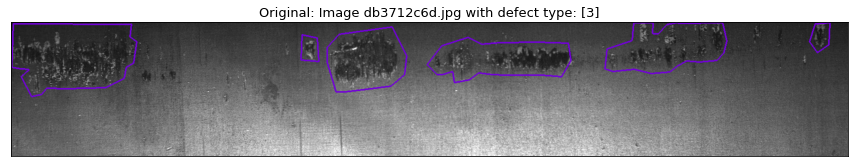

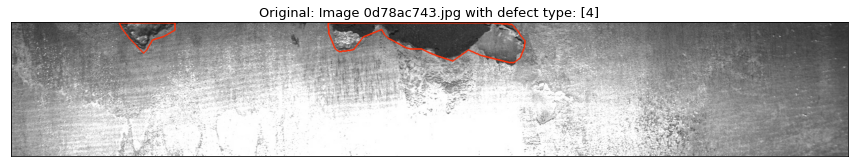

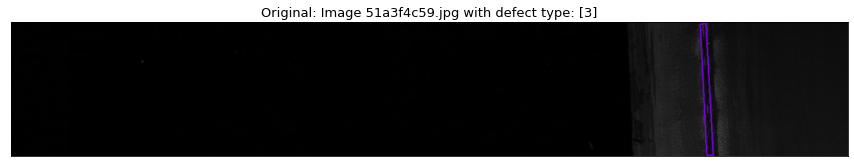

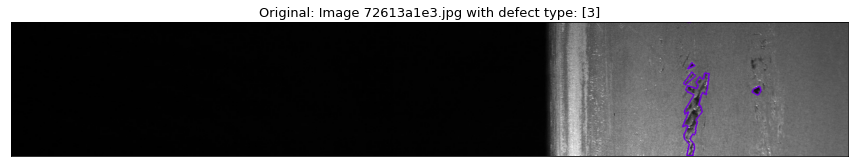

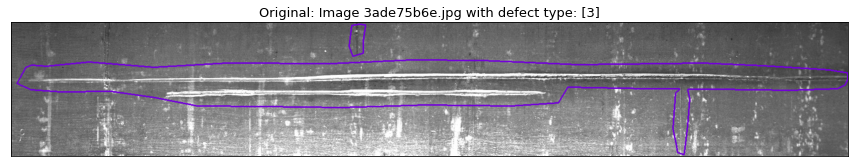

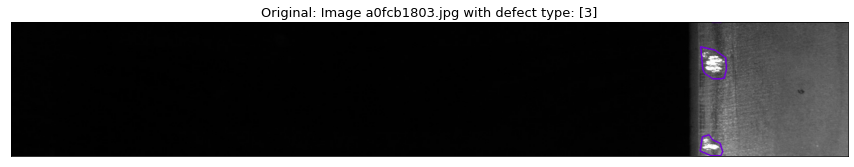

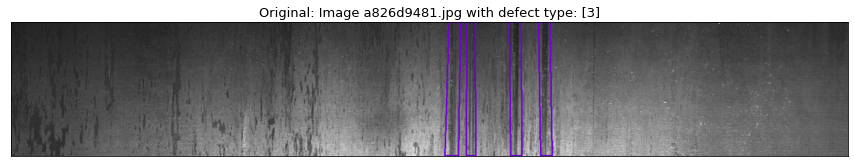

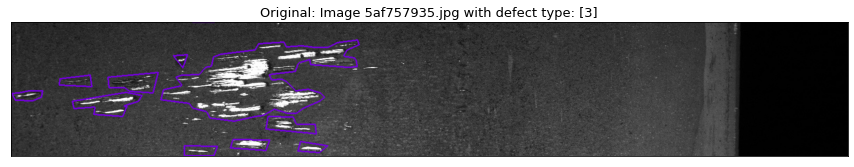

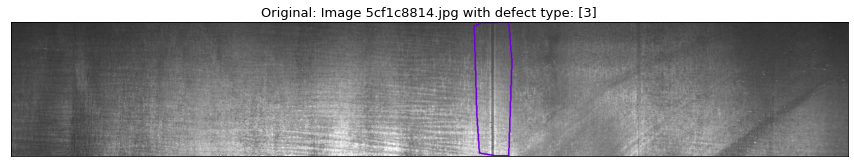

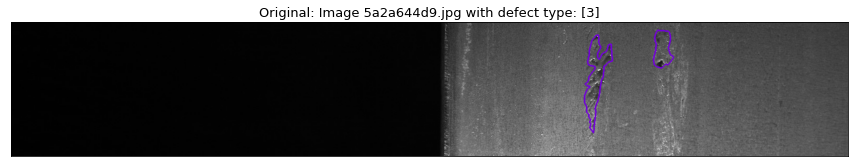

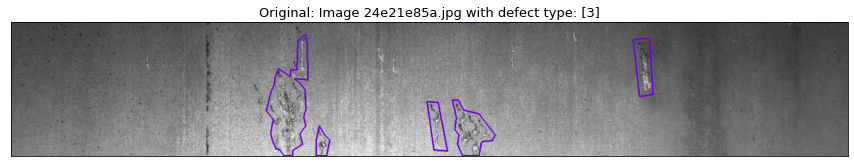

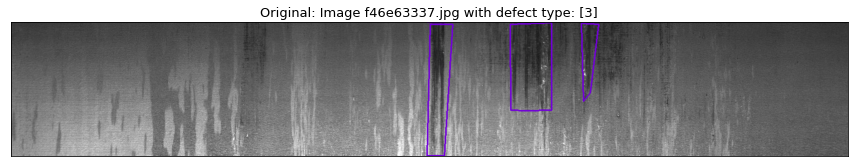

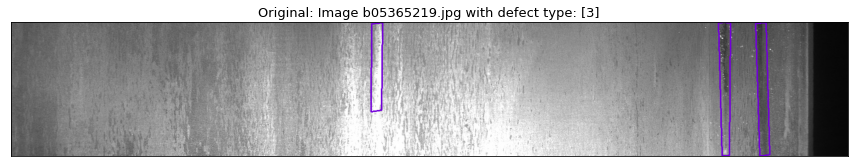

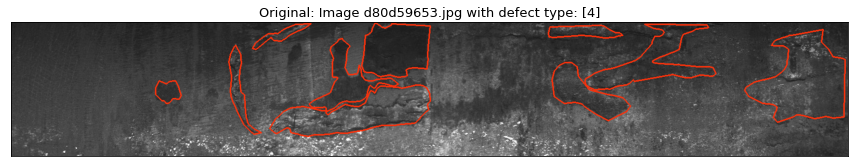

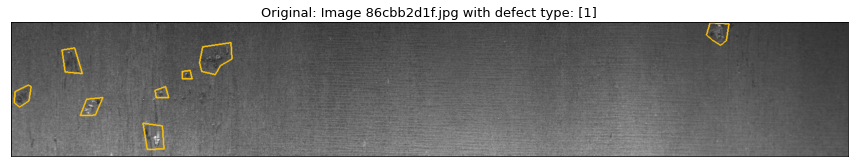

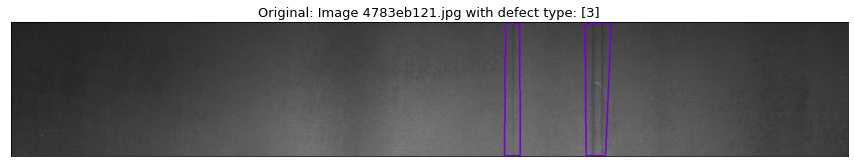

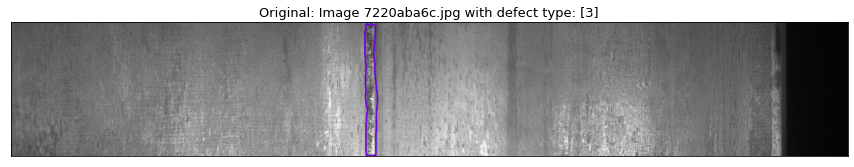

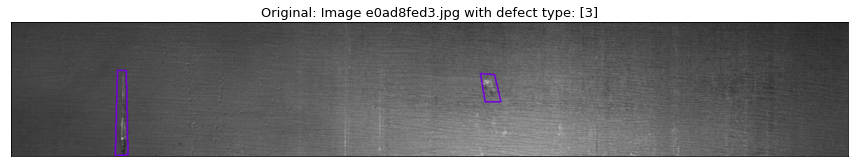

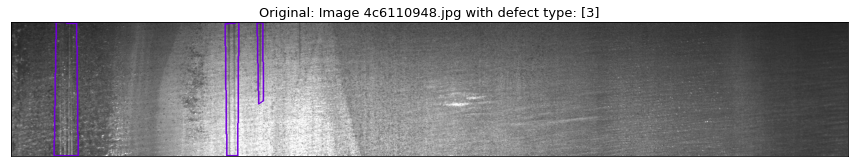

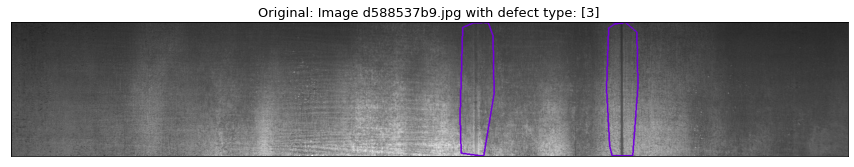

In [44]:
show_defects(path, train_pivot)